In [14]:
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

In [15]:
def load_initial_data(inputs_file, outputs_file) -> pd.DataFrame:
    X = np.load(inputs_file)
    y = np.load(outputs_file)
    df = pd.DataFrame(X, columns=['x1', 'x2', 'x3'])
    df['y'] = y
    return df

df1 = load_initial_data(
    '../initial_data/function_3/initial_inputs.npy',
    '../initial_data/function_3/initial_outputs.npy',
)
df2 = load_initial_data(
    '../initial_data2/function_3/initial_inputs.npy',
    '../initial_data2/function_3/initial_outputs.npy',
)

df = pd.concat([df1, df2], ignore_index=True)

df.head()


,x1,x2,x3,y
0,0.171525,0.343917,0.248737,-0.112122
1,0.242114,0.644074,0.272433,-0.087963
2,0.534906,0.398501,0.173389,-0.111415
3,0.492581,0.611593,0.340176,-0.034835
4,0.134622,0.219917,0.458206,-0.048008


In [16]:
import re

df_feedback = pd.read_csv('../initial_data/561_data.csv')

df_feedback = df_feedback[['f3', 'f3_output']]
df_feedback['f3'] = df_feedback['f3'].apply(lambda x: re.findall(r'\d+\.\d*', x))

for i in range(len(df_feedback['f3'].iloc[0])):
    df_feedback[f'x{i+1}'] = df_feedback['f3'].apply(lambda x: float(x[i]))

df_feedback.drop('f3', axis=1, inplace=True)
df_feedback = df_feedback.rename(columns={'f3_output': 'y'})
df_feedback = df_feedback[['x1', 'x2', 'x3', 'y']]

df = pd.concat([df, df_feedback], ignore_index=True)
df.describe()

,x1,x2,x3,y
count,37.000000,37.000000,37.000000,37.000000
mean,0.498391,0.429220,0.585701,-0.167390
std,0.299463,0.251746,0.325592,0.160279
min,0.046809,0.000000,0.065468,-0.531265
25%,0.220549,0.243332,0.269363,-0.131461
50%,0.470275,0.397143,0.566829,-0.110621
75%,0.746912,0.644074,0.898496,-0.074789
max,0.999999,0.941360,0.999999,-0.025146


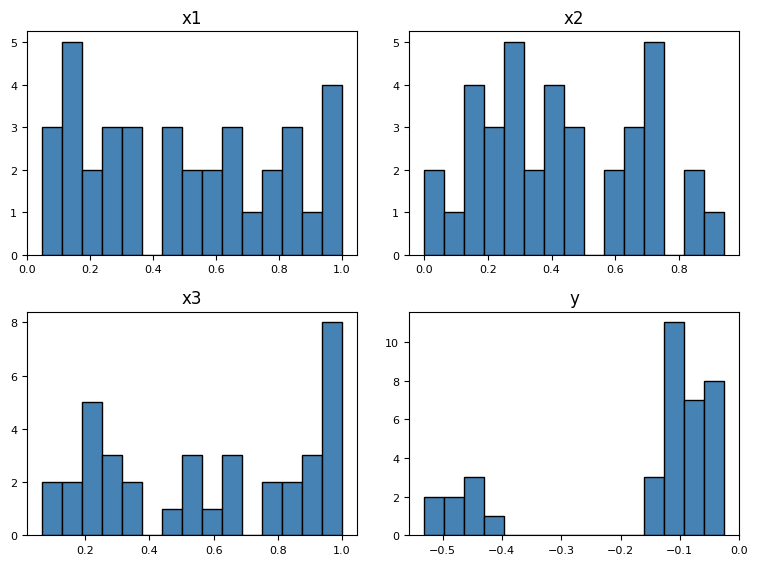

In [17]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [18]:
def analyse_param(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot histogram
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Frequency")
    axes[0].hist(df[x], bins=15, color='steelblue', edgecolor='black', linewidth=1.0)

    # Plot density
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Frequency")
    sns.kdeplot(df[x], ax=axes[1], color='steelblue', shade=True, legend=False)

    # Plot scatter
    axes[2].set_xlabel(x)
    axes[2].set_ylabel(y)
    axes[2].scatter(df[x], df[y], s=30, edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()


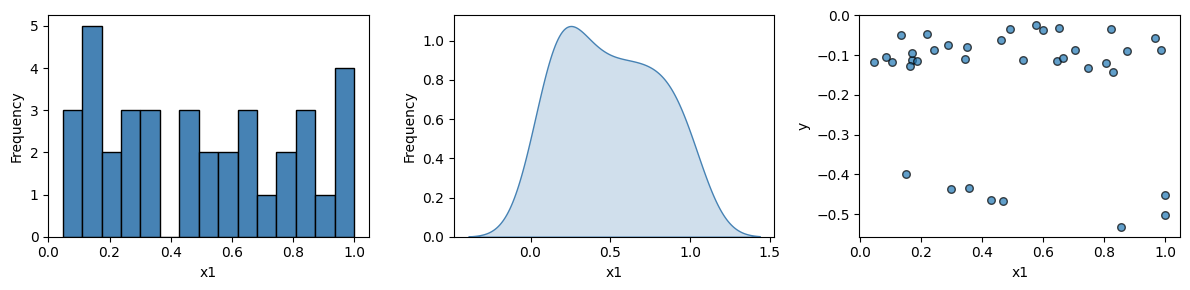

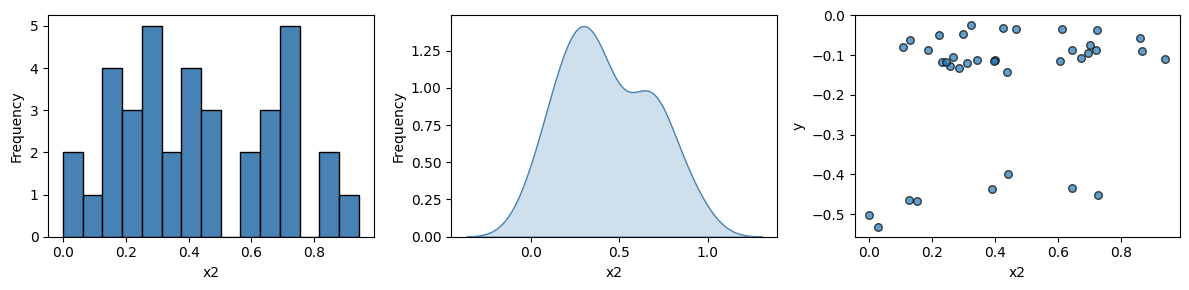

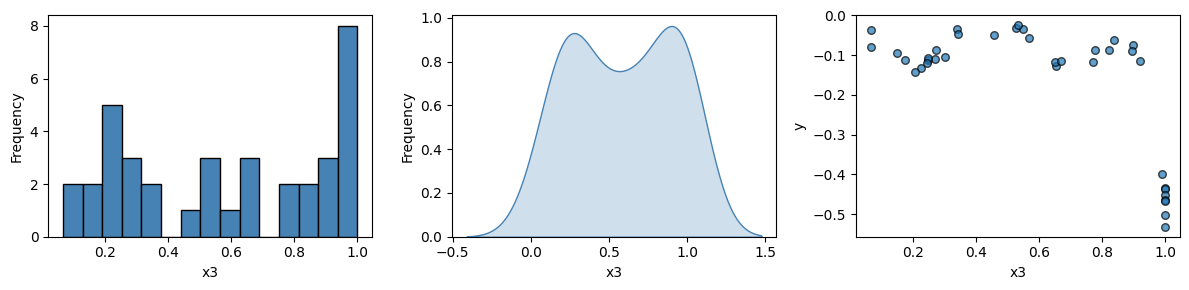

In [19]:
analyse_param(df, 'x1', 'y')
analyse_param(df, 'x2', 'y')
analyse_param(df, 'x3', 'y')

In [20]:
def analyse_corr_to_y(df):
    # Plot correlation to y
    corr = df.corr()
    sns.heatmap(corr[['y']], annot=True, cmap='coolwarm')

    # Analyse correlation of variables to y
    g = sns.PairGrid(df, y_vars=["y"], x_vars=["x1", "x2", "x3"])
    g.map(sns.regplot, color='steelblue')

    plt.tight_layout()
    plt.show()

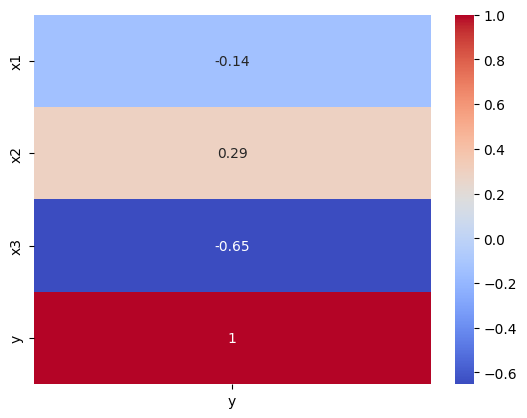

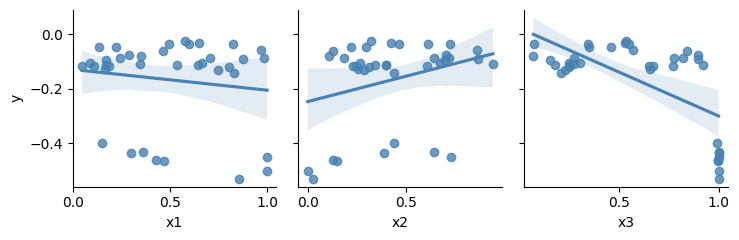

In [21]:
analyse_corr_to_y(df)

In [22]:
def pairwise_relationship(df):
    sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'black'})
    plt.tight_layout()
    plt.show()

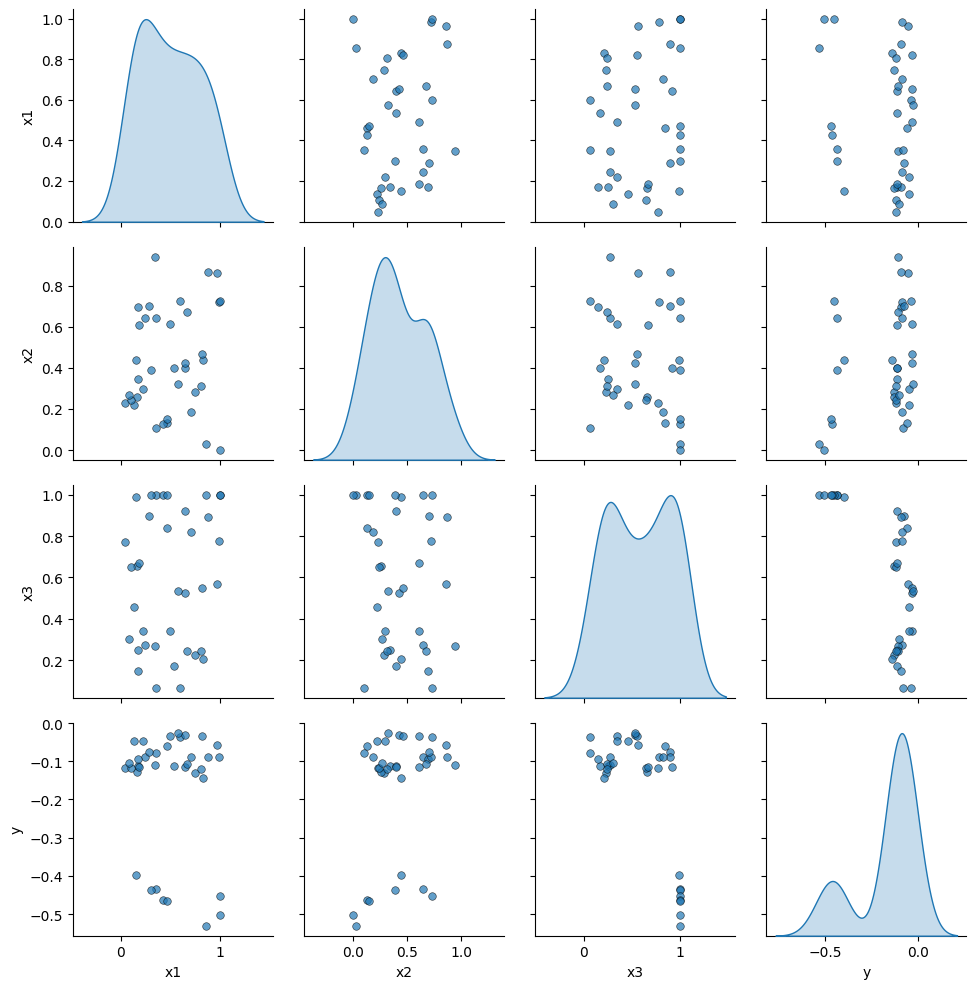

In [23]:
pairwise_relationship(df)

In [24]:
def objective_fn(x):
    return np.abs([x[:, 0] + x[:, 1] + x[:, 2]])

objective = GPyOpt.core.task.SingleObjective(objective_fn)

space = GPyOpt.Design_space(
    space=[{'name': 'x1', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 0.999999)}]
)

gp_kernel = GPy.kern.RBF(
    input_dim=3,
    variance=1.0,
    ARD=True
)

model = GPyOpt.models.GPModel(
    exact_feval=False,
    optimize_restarts=5,
    verbose=False,
    kernel=gp_kernel
)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, acquisition_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator,
    X_init=df[['x1', 'x2', 'x3']].values,
    Y_init=df['y'].values.reshape(-1, 1),
    de_duplication=True
)

In [25]:
bo.plot_acquisition()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
x_next = bo.suggest_next_locations()
print(f"next_query: {'-'.join(['%.6f' % x for x in x_next[0]])}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
